In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import os

MIN_ATTEMPTS = 5  
CONTAMINATION_RATE = 0.03  
K_CHOICE = (
    4  
)
RANDOM_STATE = 42

df = pd.read_csv("./data/data.csv", encoding="latin-1", sep=";")


mydict = {
    "Student ID": "student_id",
    "Student Country": "country",
    "Question ID": "question_id",
    "Type of Answer": "is_correct",
    "Question Level": "q_level",
    "Topic": "topic",
    "Subtopic": "subtopic",
    "Keywords": "keywords",
}
df = df.rename(columns=mydict)
df.drop_duplicates(inplace=True)

print(f"Data loaded and cleaned. Total interactions remaining: {df.shape[0]}")

Data loaded and cleaned. Total interactions remaining: 7463


In [ ]:

final_df = (
    df.groupby("student_id")
    .agg({"is_correct": "mean", "question_id": "count"})
    .rename(columns={"is_correct": "Avg_Accuracy", "question_id": "Total_Questions"})
)


difficulty_stats = df.pivot_table(
    index="student_id", columns="q_level", values="is_correct", aggfunc="mean"
).fillna(0)
difficulty_stats.columns = ["Acc_" + str(c) for c in difficulty_stats.columns]


topic_stats = df.groupby("student_id")["topic"].nunique()
topic_stats.name = "Topic_Diversity"


X = final_df.join(difficulty_stats).join(topic_stats).fillna(0)
X = X[X["Total_Questions"] >= MIN_ATTEMPTS]  


FEATURE_COLS = X.columns.tolist()

print(f"Feature Engineering Complete. {X.shape[0]} students (profiles) created.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[FEATURE_COLS])
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS, index=X.index)


iso_forest = IsolationForest(
    n_estimators=100, contamination=CONTAMINATION_RATE, random_state=RANDOM_STATE
)
anomaly_labels = iso_forest.fit_predict(X_scaled_df)
X["Anomaly_Label"] = anomaly_labels


df_normal = X[X["Anomaly_Label"] == 1].drop(columns=["Anomaly_Label"])
df_anomalies = X[X["Anomaly_Label"] == -1].drop(columns=["Anomaly_Label"])

print(f"\nAnomalies removed: {df_anomalies.shape[0]} rows.")
print(f"Clean Data for Clustering (df_normal): {df_normal.shape[0]} rows.")

Feature Engineering Complete. 316 students (profiles) created.

Anomalies removed: 10 rows.
Clean Data for Clustering (df_normal): 306 rows.


PCA Variance Explained: PC1=0.38, PC2=0.28


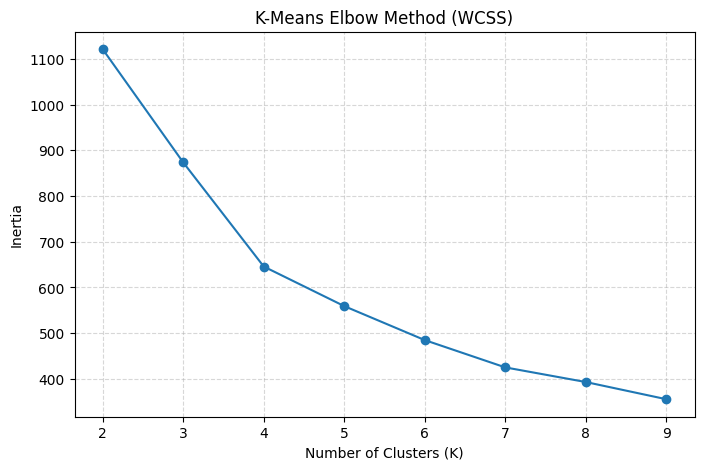

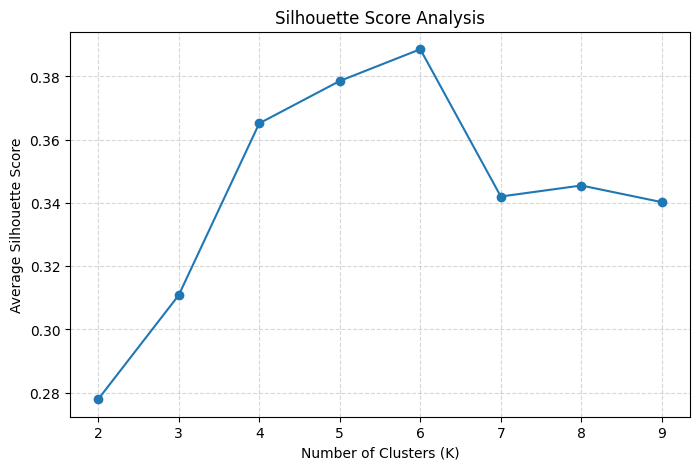

In [ ]:

scaler_clean = StandardScaler()
X_clean_scaled = scaler_clean.fit_transform(df_normal[FEATURE_COLS])
X_clean_scaled_df = pd.DataFrame(
    X_clean_scaled, columns=FEATURE_COLS, index=df_normal.index
)


pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_clean_scaled_df)
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"], index=df_normal.index)

print(
    f"PCA Variance Explained: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}"
)

inertia_values = []
K_range = range(2, 10)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_temp.fit(X_clean_scaled_df)
    inertia_values.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker="o")
plt.title("K-Means Elbow Method (WCSS)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

silhouette_scores = []
K_range = range(2, 10)  

for k in K_range:
    
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(X_clean_scaled_df)
    score = silhouette_score(X_clean_scaled_df, cluster_labels)
    silhouette_scores.append(score)


plt.figure(figsize=(8, 5))

plt.plot(K_range, silhouette_scores, marker="o")
plt.title("Silhouette Score Analysis")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

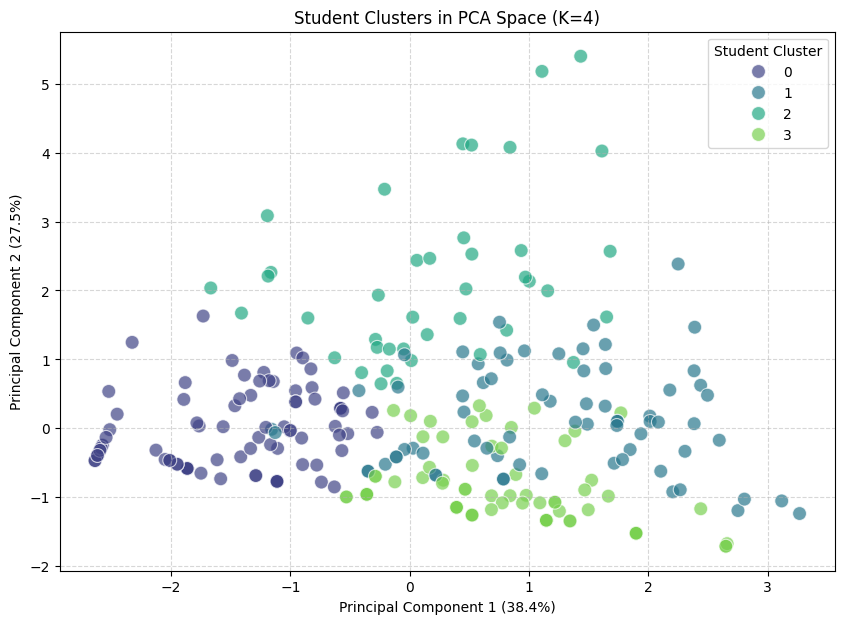


--- CLUSTER PROFILES (Centroids) ---
         Avg_Accuracy  Total_Questions  Acc_Advanced  Acc_Basic  \
Cluster                                                           
0            0.182552        15.480392      0.035747   0.174999   
1            0.604647        26.985915      0.675217   0.458847   
2            0.406354        44.414634      0.083978   0.422088   
3            0.608003        11.554348      0.007712   0.619795   

         Topic_Diversity  
Cluster                   
0               1.196078  
1               1.253521  
2               2.853659  
3               1.119565  


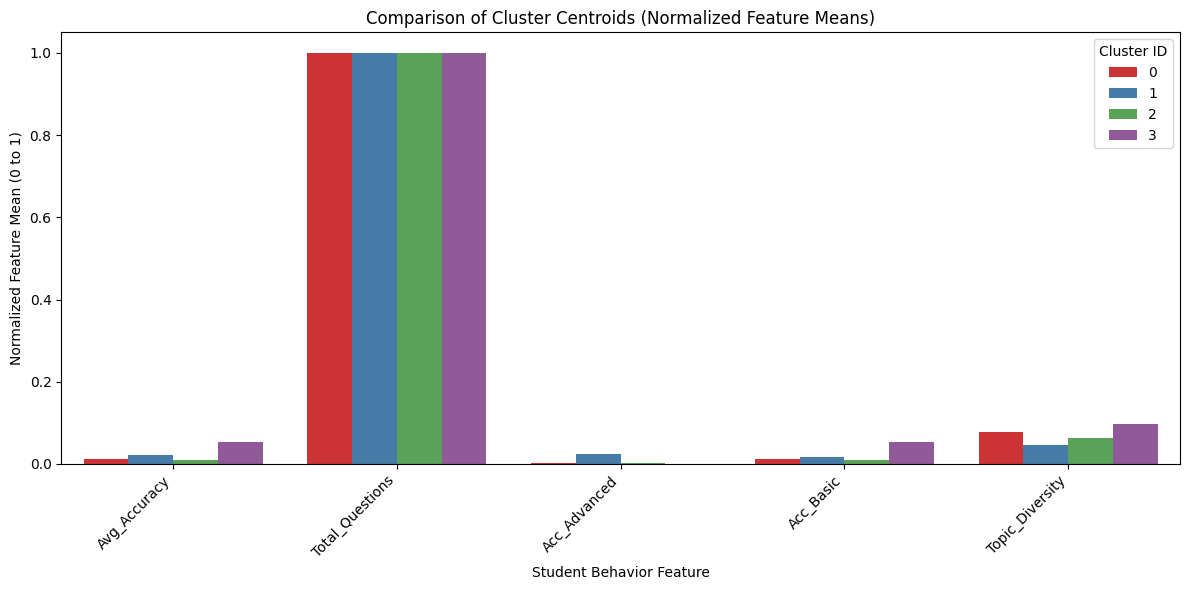

In [ ]:



kmeans_final = KMeans(n_clusters=K_CHOICE, random_state=RANDOM_STATE, n_init=10)
kmeans_final.fit(X_clean_scaled_df)


df_normal["Cluster"] = kmeans_final.labels_
pca_df["Cluster"] = kmeans_final.labels_
pca_df["Cluster"] = pca_df["Cluster"].astype("category")  



plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Cluster",
    data=pca_df,
    palette="viridis",
    s=100,
    alpha=0.7,
)
plt.title(f"Student Clusters in PCA Space (K={K_CHOICE})")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Student Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

cluster_profiles = df_normal.groupby("Cluster")[FEATURE_COLS].mean()
print("\n--- CLUSTER PROFILES (Centroids) ---")
print(cluster_profiles)


normalized_profiles = cluster_profiles.apply(lambda x: x / x.max(), axis=1)
plot_data = normalized_profiles.reset_index().melt(
    id_vars="Cluster", var_name="Feature", value_name="Mean_Value"
)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Mean_Value", hue="Cluster", data=plot_data, palette="Set1")
plt.title("Comparison of Cluster Centroids (Normalized Feature Means)")
plt.ylabel("Normalized Feature Mean (0 to 1)")
plt.xlabel("Student Behavior Feature")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster ID")
plt.tight_layout()
plt.show()